In [9]:
import pandas as pd
import numpy as np
from datetime import date
import holidays
from sklearn.preprocessing import MinMaxScaler

In [10]:
# Load the data
df = pd.read_csv("../data/all_terciaria_merged/pivoted_quarterly.csv",index_col=[0],parse_dates=[0])

We read the csv that I prepared that contains indicators whose description either contains the word "generation" or "terciaria" as we want to predict target1:"terciaria a bajar" or target2:"terciaria a subir", respectively, ids "10394" and "10395". The dataframe is indexed by hour. Higher frequency data (quarterly for example) is pivoted to columns, so that a variable column1 that has data on 00, 15, 30 and 45 min is converted onto four columns column1.xx for xx in minutes. Higher than quarterly frequency data (five minutes) has been deleted. Further work should perhaps include it and also do a correlation study to find out if we can delete some features that are irrelevant to target1 and target2

In [11]:
df['H'] = df.index.hour/24 # df.index.hour
# df['D'] = df.index.day
# df['M'] = np.cos(df.index.month*2*np.pi/12)
df['Dyear'] = df.index.dayofyear/365
df['BOOL_HOLIDAYS'] = [day in holidays.ESP() for day in df.index]
# df['Y'] = df['datetime'].dt.year #? it is absurd what are you gonna learn from this?
# Extract the day of the week (0 = Monday, 6 = Sunday)
df['day_of_week'] = df.index.dayofweek

# Apply one-hot encoding for 'day_of_week'
one_hot = pd.get_dummies(df['day_of_week'], prefix='day', drop_first=True)  # drop_first=True removes one dummy column to avoid the trap

# Concatenate the original DataFrame with the one-hot encoded columns
df = pd.concat([df, one_hot], axis=1)

# Drop the original 'day_of_week' column if no longer needed
df.drop(columns=['day_of_week'], inplace=True)
# Extract target columns
target_cols = ['10394.00', '10394.15', '10394.30', '10394.45', '10395.00', '10395.15', '10395.30', '10395.45']
target_idx = [df.columns.get_loc(col) for col in target_cols]

We need to reescale the data frame so that values are somewhat normalized

In [12]:
scaler_X = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler_X.fit_transform(df[:])
scaler_y = MinMaxScaler(feature_range=(0,1))
scaled_target = scaler_y.fit_transform(df.iloc[:,target_idx])
# scaled_data[:,target_idx] == scaled_target is true

In [15]:
def create_sequences(scaled_data, scaled_target, input_len=24, delay=2):
    X, y = [], []
    for i in range(len(scaled_data) - input_len - delay):
        X.append(scaled_data[i:i + input_len,:])   # 24 hours as input
        y.append(scaled_target[i + input_len + delay - 1,:])  # 26th hour as output (input_len + delay)
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data,scaled_target)

train_percentage = 0.99
train_idx = int(train_percentage*X.shape[0])
X_train, y_train = X[:train_idx], y[:train_idx]
X_test, y_test = X[train_idx:], y[train_idx:] 

In [61]:
import matplotlib.pyplot as plt

def ts_plot(y_test, y_pred, name, loss):
    pred_94 = y_pred[:,:4].flatten()
    pred_95 = y_pred[:,4:].flatten()
    test_94 = y_test[:,:4].flatten()
    test_95 = y_test[:,4:].flatten()

    fig, axs = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

    # Plot for pred_94 vs. test_94
    axs[0].plot(pred_94, label='Predictions', color='blue', alpha=0.7)
    axs[0].plot(test_94, label='Observations', color='orange', alpha=0.7)
    axs[0].set_title(f'2h Ahead 10394 {name}', fontsize=16)
    axs[0].set_ylabel('Values', fontsize=14)
    axs[0].legend(loc='upper right', fontsize=12)
    axs[0].grid(True, linestyle='--', linewidth=0.7)
    axs[0].tick_params(axis='both', which='major', labelsize=12)

    # Plot for pred_95 vs. test_95
    axs[1].plot(pred_95, label='Predictions', color='green', alpha=0.7)
    axs[1].plot(test_95, label='Observations', color='red', alpha=0.7)
    axs[1].set_title(f'2h Ahead 10395 {name}', fontsize=16)
    axs[1].set_xlabel('Time', fontsize=14)
    axs[1].set_ylabel('Values', fontsize=14)
    axs[1].legend(loc='upper right', fontsize=12)
    axs[1].grid(True, linestyle='--', linewidth=0.7)
    axs[1].tick_params(axis='both', which='major', labelsize=12)

    # Add the overall title with the loss value
    plt.suptitle(f'{name} - 2h Ahead Forecast - Loss: {loss:.4f}', fontsize=18)

    # Adjust layout to ensure subplots fit within the figure area
    plt.tight_layout()  # rect ensures the title fits

    # Save the figure as a PNG file
    plt.savefig(f"../figs/2h_ahead_terciaria_{name}.png", dpi=300)

    # Show the plots
    plt.show()


Los datos y el target, pares X[i] e y[i] for i in range(X.shape[0]) estan ya hechos, solo nos falta entrenarlos, no lo hacemos con LSTM en Keras (ni XGBoost) porque pretendemos aplicar los SOTA predictors, que estan en Pytorch
# LSTM en Pytorch

NN is trained! Now renormalize

In [81]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the LSTM model in PyTorch
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        # Fully connected layer (Dense equivalent)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(1, x.size(0), 50).to(x.device)  # 1 for one layer
        c0 = torch.zeros(1, x.size(0), 50).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        # Only use the output of the last time step
        out = out[:, -1, :]
        # Pass the last time step output to the fully connected layer
        out = self.fc(out)
        return out

# Hyperparameters
input_size = X_train.shape[2]  # The number of features in input
hidden_size = 50               # 50 LSTM units
output_size = len(target_cols)  # The number of target columns

# Initialize the model
model = LSTMModel(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Training loop
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # Training step
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            val_outputs = model(X_val_batch)
            v_loss = criterion(val_outputs, y_val_batch)
            val_loss += v_loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}')


/tmp/ipykernel_10746/2808063333.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
/tmp/ipykernel_10746/2808063333.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
/tmp/ipykernel_10746/2808063333.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
/tmp/ipykernel_10746/2808063333.py:44: UserWarning: To copy construct from a tensor, it is recommended to use s

Epoch [1/25], Loss: 0.0107, Val Loss: 0.0126
Epoch [2/25], Loss: 0.0098, Val Loss: 0.0128
Epoch [3/25], Loss: 0.0096, Val Loss: 0.0120
Epoch [4/25], Loss: 0.0095, Val Loss: 0.0119
Epoch [5/25], Loss: 0.0093, Val Loss: 0.0121
Epoch [6/25], Loss: 0.0092, Val Loss: 0.0116
Epoch [7/25], Loss: 0.0091, Val Loss: 0.0116
Epoch [8/25], Loss: 0.0090, Val Loss: 0.0117
Epoch [9/25], Loss: 0.0089, Val Loss: 0.0115
Epoch [10/25], Loss: 0.0088, Val Loss: 0.0119
Epoch [11/25], Loss: 0.0088, Val Loss: 0.0114
Epoch [12/25], Loss: 0.0087, Val Loss: 0.0118
Epoch [13/25], Loss: 0.0086, Val Loss: 0.0114
Epoch [14/25], Loss: 0.0086, Val Loss: 0.0113
Epoch [15/25], Loss: 0.0084, Val Loss: 0.0116
Epoch [16/25], Loss: 0.0084, Val Loss: 0.0112
Epoch [17/25], Loss: 0.0084, Val Loss: 0.0115
Epoch [18/25], Loss: 0.0083, Val Loss: 0.0112
Epoch [19/25], Loss: 0.0082, Val Loss: 0.0112
Epoch [20/25], Loss: 0.0082, Val Loss: 0.0116
Epoch [21/25], Loss: 0.0081, Val Loss: 0.0110
Epoch [22/25], Loss: 0.0081, Val Loss: 0.01

Then we plot

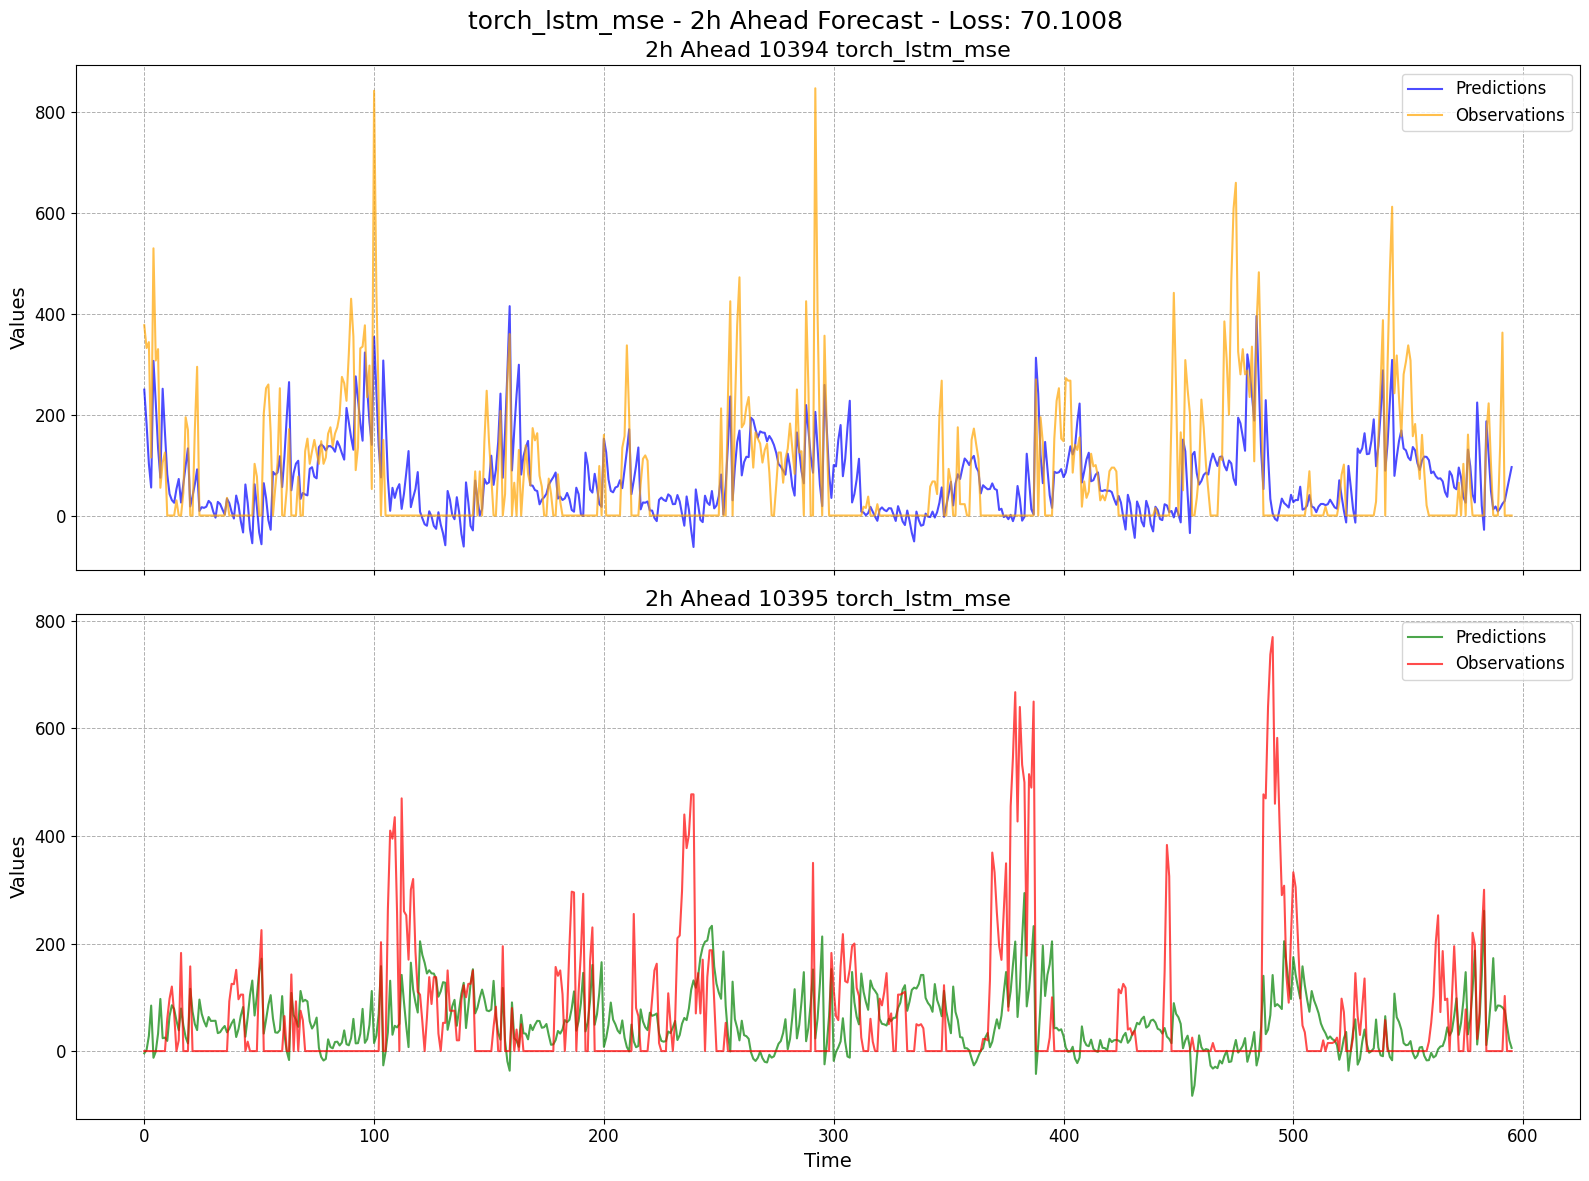

In [82]:
with torch.no_grad():
    y_pred = scaler_y.inverse_transform(model(X_test).detach().numpy())
    y_true = scaler_y.inverse_transform(y_test.detach().numpy())
criterion = nn.L1Loss()
ts_plot(y_true,y_pred,'torch_lstm_mse',loss=criterion(torch.tensor(y_pred),torch.tensor(y_true)))

Now with mean absolute error

In [76]:
# Initialize the model
model = LSTMModel(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
# Define the loss function and optimizer
criterion = nn.L1Loss() # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Training loop
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # Training step
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            val_outputs = model(X_val_batch)
            v_loss = criterion(val_outputs, y_val_batch)
            val_loss += v_loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}')


/tmp/ipykernel_10746/2110700173.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
/tmp/ipykernel_10746/2110700173.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
/tmp/ipykernel_10746/2110700173.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
/tmp/ipykernel_10746/2110700173.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sou

Epoch [1/25], Loss: 0.0640, Val Loss: 0.0669
Epoch [2/25], Loss: 0.0607, Val Loss: 0.0662
Epoch [3/25], Loss: 0.0597, Val Loss: 0.0657
Epoch [4/25], Loss: 0.0588, Val Loss: 0.0655
Epoch [5/25], Loss: 0.0582, Val Loss: 0.0647
Epoch [6/25], Loss: 0.0578, Val Loss: 0.0639
Epoch [7/25], Loss: 0.0575, Val Loss: 0.0644
Epoch [8/25], Loss: 0.0571, Val Loss: 0.0637
Epoch [9/25], Loss: 0.0569, Val Loss: 0.0637
Epoch [10/25], Loss: 0.0566, Val Loss: 0.0644
Epoch [11/25], Loss: 0.0564, Val Loss: 0.0630
Epoch [12/25], Loss: 0.0563, Val Loss: 0.0637
Epoch [13/25], Loss: 0.0559, Val Loss: 0.0641
Epoch [14/25], Loss: 0.0558, Val Loss: 0.0638
Epoch [15/25], Loss: 0.0556, Val Loss: 0.0628
Epoch [16/25], Loss: 0.0554, Val Loss: 0.0638
Epoch [17/25], Loss: 0.0553, Val Loss: 0.0650
Epoch [18/25], Loss: 0.0551, Val Loss: 0.0641
Epoch [19/25], Loss: 0.0549, Val Loss: 0.0637
Epoch [20/25], Loss: 0.0547, Val Loss: 0.0646
Epoch [21/25], Loss: 0.0546, Val Loss: 0.0639
Epoch [22/25], Loss: 0.0545, Val Loss: 0.06

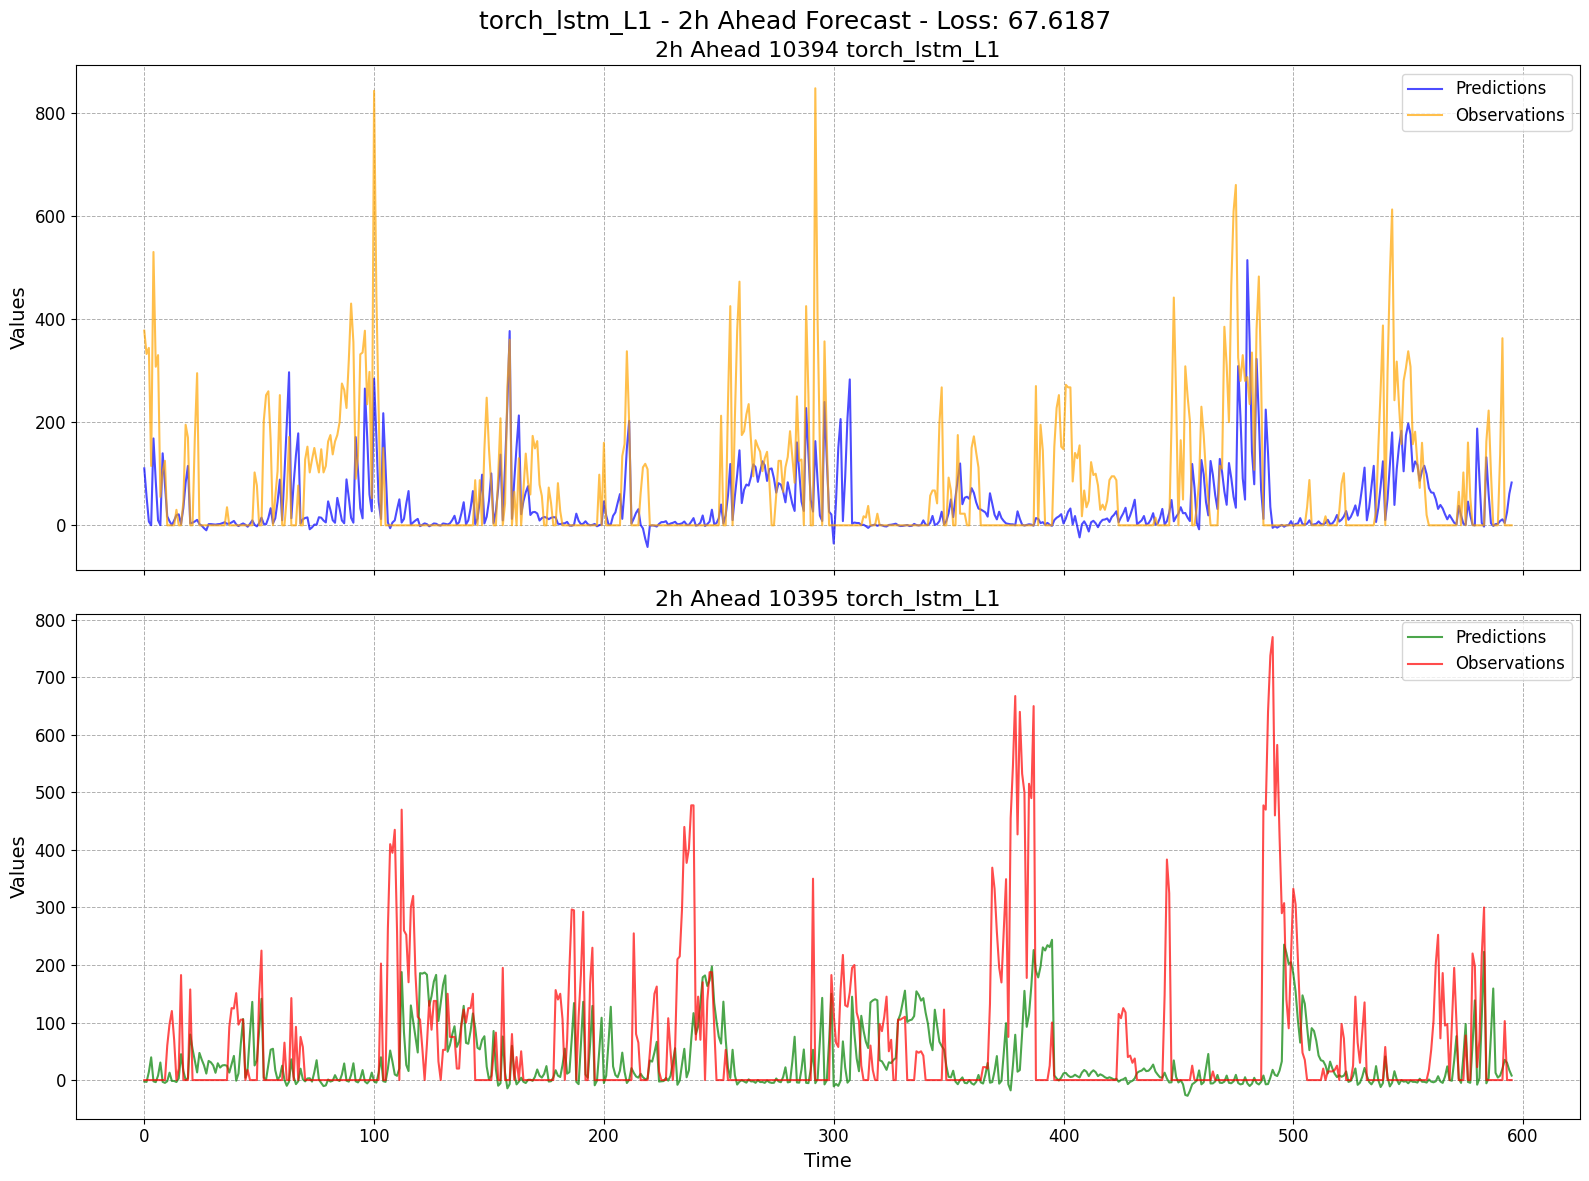

In [78]:
with torch.no_grad():
    y_pred = scaler_y.inverse_transform(model(X_test).detach().numpy())
    y_true = scaler_y.inverse_transform(y_test.detach().numpy())
ts_plot(y_true,y_pred,'torch_lstm_L1',loss=criterion(torch.tensor(y_pred),torch.tensor(y_true)))

# 3. Timesnet

# 2. Keras

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

2024-09-17 16:07:45.274310: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-17 16:07:45.283742: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-17 16:07:45.286321: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-17 16:07:45.294874: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-17 16:07:46.096970: W tensorflow/compiler/tf2

In [12]:
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))  # 24-hour input sequence
model.add(Dense(len(target_cols)))  # Output for each of the columns
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/25


2024-09-17 11:57:45.373209: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/home/aner/.venvs/energy/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0176 - val_loss: 0.0116
Epoch 2/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0100 - val_loss: 0.0112
Epoch 3/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0099 - val_loss: 0.0111
Epoch 4/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0095 - val_loss: 0.0110
Epoch 5/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0096 - val_loss: 0.0106
Epoch 6/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0096 - val_loss: 0.0106
Epoch 7/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0093 - val_loss: 0.0105
Epoch 8/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0091 - val_loss: 0.0107
Epoch 9/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0091 - val_loss: 0.0111
Epoch 10/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0091 - val_loss: 0.0103
Epoch 11/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0091 - val_loss: 0.0104
Epoch 12/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/ste

In [118]:
model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0171 - val_loss: 0.0115
Epoch 2/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0099 - val_loss: 0.0117
Epoch 3/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0096 - val_loss: 0.0109
Epoch 4/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0097 - val_loss: 0.0110
Epoch 5/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0095 - val_loss: 0.0111
Epoch 6/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0096 - val_loss: 0.0106
Epoch 7/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0093 - val_loss: 0.0105
Epoch 8/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0094 - val_loss: 0.0105
Epoch 9/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0091 - val_loss: 0.0103
Epoch 10/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0089 - val_loss: 0.0104
Epoch 11/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0091 - val_loss: 0.0104
Epoch 12/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step

In [119]:
keras_y_pred = scaler_y.inverse_transform(model.predict(X_test))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


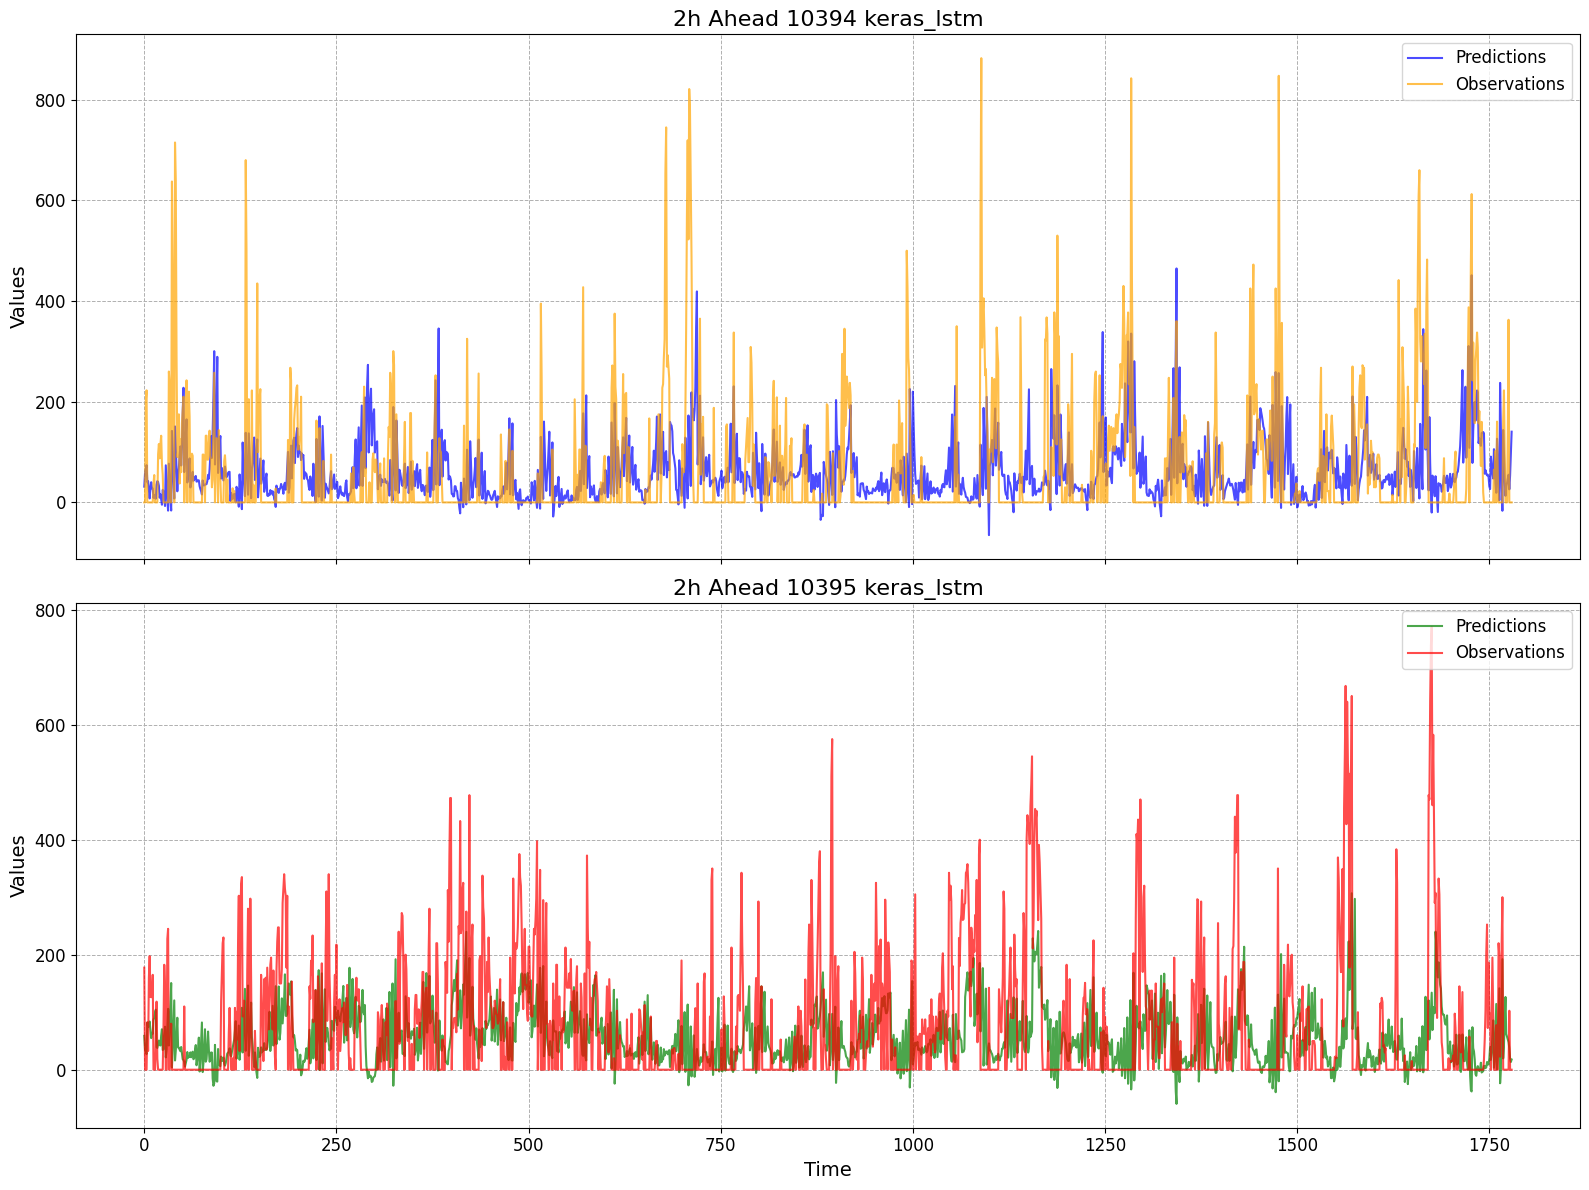

In [121]:
plt.close()
ts_plot(y_true,keras_y_pred,'keras_lstm')

# Keras 2: CNN-LSTM moment

In [123]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector

In [124]:
metric = [tf.keras.metrics.RootMeanSquaredError()]

In [132]:
tf.keras.backend.clear_session()

multivariate_cnn_lstm = tf.keras.models.Sequential([
    Conv1D(filters=100, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(100, return_sequences=True),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(len(target_cols))
])


multivariate_cnn_lstm.compile(loss='mean_squared_error',
                          optimizer='Adam',
                          metrics=metric)

/home/aner/.venvs/energy/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [133]:
multivariate_cnn_lstm.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.0169 - root_mean_squared_error: 0.1219 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1132
Epoch 2/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0101 - root_mean_squared_error: 0.1005 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1067
Epoch 3/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0095 - root_mean_squared_error: 0.0975 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1053
Epoch 4/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0093 - root_mean_squared_error: 0.0963 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1049
Epoch 5/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0091 - root_mean_squared_error: 0.0955 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1030
Epoch 6/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0089 - root_mean_squared_error: 0.0944 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1060
Epoch 7/25
449/449 ━━━━━━━━━━━━━━━━━━━━ 6s 13m

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


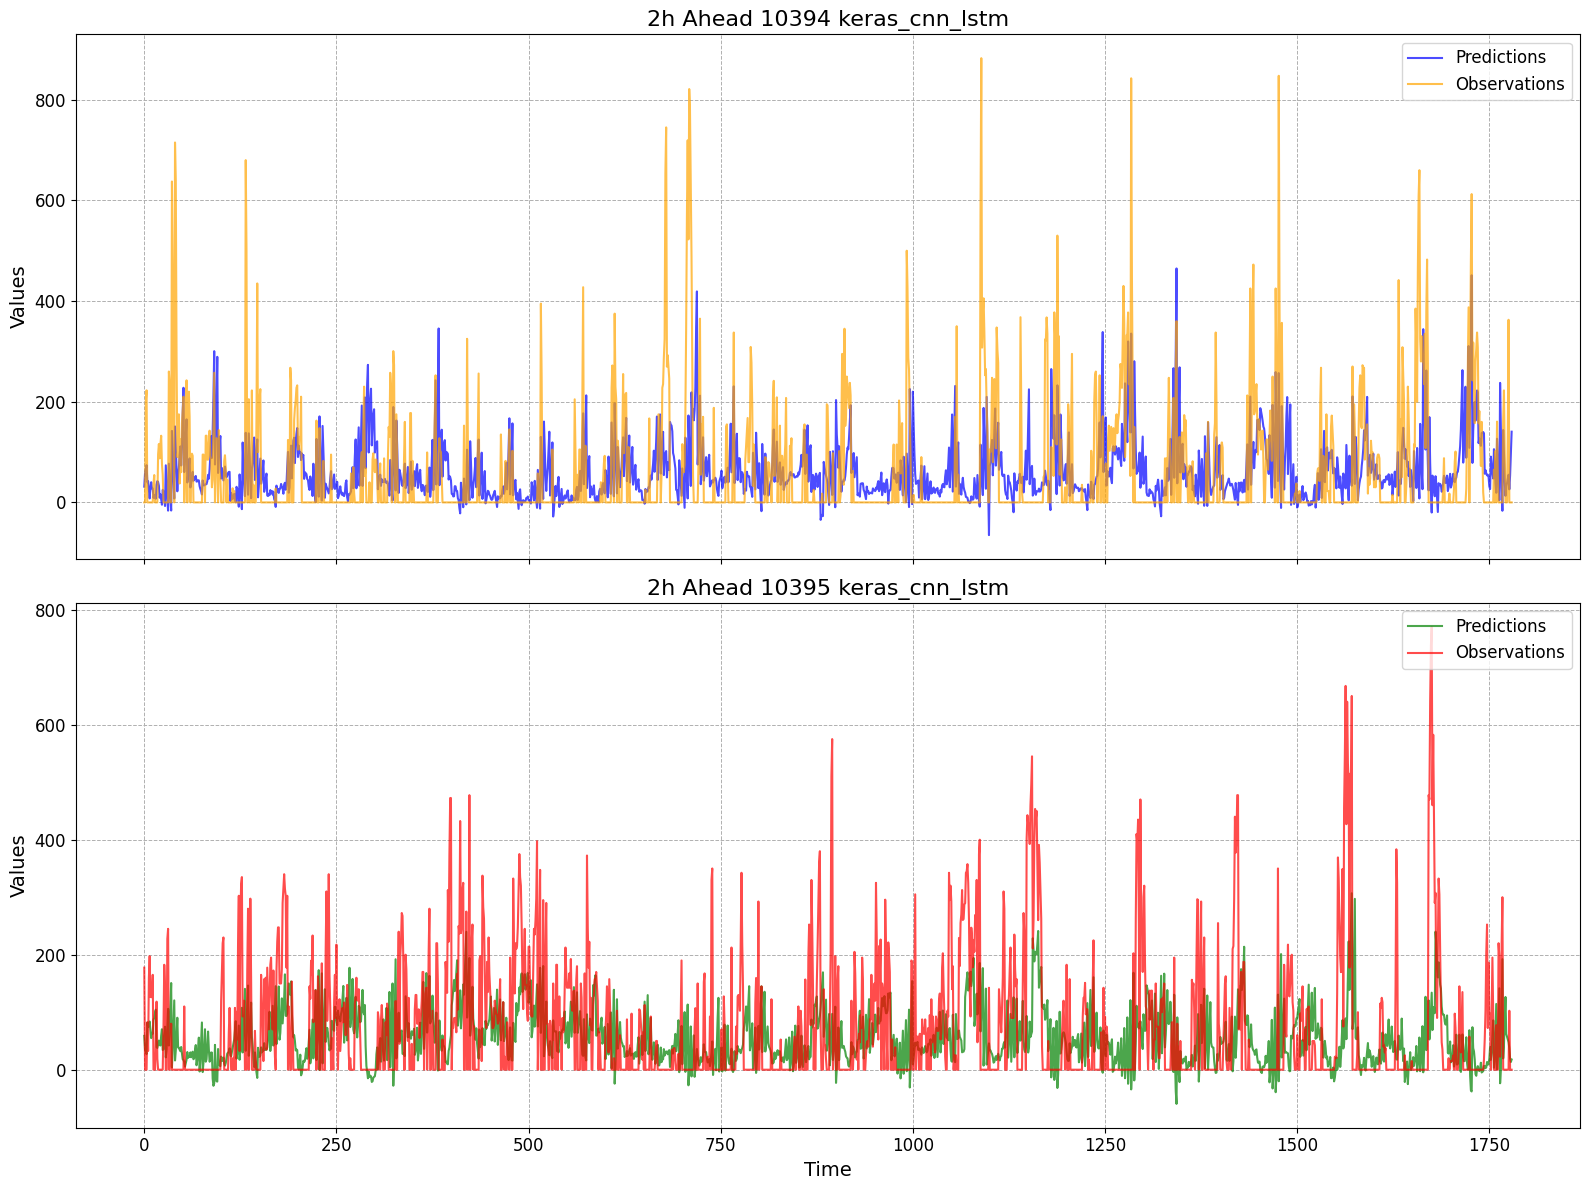

In [134]:
y_test = scaler_y.inverse_transform(multivariate_cnn_lstm.predict(X_test))
ts_plot(y_true,keras_y_pred,'keras_cnn_lstm')

# ENCODER-DECODER

In [135]:
past_history = 48

In [ ]:
tf.keras.backend.clear_session()

encoder_decoder = tf.keras.models.Sequential([
    LSTM(50, activation='relu', input_shape=input_shape),
    RepeatVector(past_history),
    LSTM(50, activation='relu', return_sequences=True),
    TimeDistributed(Dense(50, activation='relu')),
    Flatten(),
    Dense(25, activation='relu'),
    Dense(1)
])



model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'encoder_decoder.h5', save_best_only=True)

optimizer = tf.keras.optimizers.Adam(lr=1e-3, amsgrad=True)

encoder_decoder.compile(loss=loss,
                    optimizer=optimizer,
                    metrics=metric)